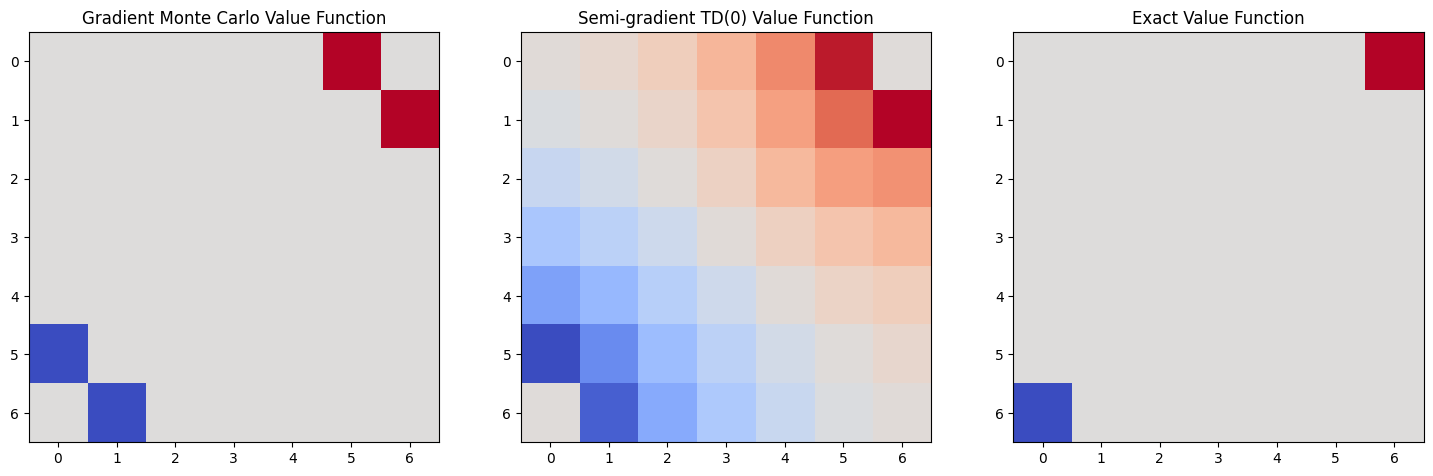

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self):
        self.size = 7
        self.start_state = (3, 3)
        self.terminal_states = {(6, 0): -1, (0, 6): 1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row = max(row - 1, 0)
        elif action == 1:  # right
            col = min(col + 1, self.size - 1)
        elif action == 2:  # down
            row = min(row + 1, self.size - 1)
        elif action == 3:  # left
            col = max(col - 1, 0)

        self.state = (row, col)
        reward = self.terminal_states.get(self.state, 0)
        done = self.state in self.terminal_states
        return self.state, reward, done

# Gradient Monte Carlo Method
def gradient_monte_carlo(env, num_episodes, alpha=0.01, gamma=0.99):
    value_function = np.zeros((env.size, env.size))
    returns = {(i, j): [] for i in range(env.size) for j in range(env.size)}

    for _ in range(num_episodes):
        episode = []
        state = env.reset()
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state
            if done:
                break

        G = 0
        for state, reward in reversed(episode):
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:-1]]:
                returns[state].append(G)
                value_function[state] += alpha * (G - value_function[state])

    return value_function

# Semi-gradient TD(0) Method
def semi_gradient_td0(env, num_episodes, alpha=0.01, gamma=0.99):
    value_function = np.zeros((env.size, env.size))

    for _ in range(num_episodes):
        state = env.reset()
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            td_target = reward + gamma * value_function[next_state]
            value_function[state] += alpha * (td_target - value_function[state])
            state = next_state
            if done:
                break

    return value_function

# Compare the methods
env = GridWorld()
num_episodes = 5000

value_function_mc = gradient_monte_carlo(env, num_episodes)
value_function_td0 = semi_gradient_td0(env, num_episodes)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(value_function_mc, cmap='coolwarm', interpolation='none')
axes[0].set_title('Gradient Monte Carlo Value Function')
axes[1].imshow(value_function_td0, cmap='coolwarm', interpolation='none')
axes[1].set_title('Semi-gradient TD(0) Value Function')
exact_value_function = np.zeros((7, 7))
exact_value_function[6, 0] = -1
exact_value_function[0, 6] = 1
axes[2].imshow(exact_value_function, cmap='coolwarm', interpolation='none')
axes[2].set_title('Exact Value Function')
plt.show()


Exact Value Function (Linear System Approach):
              0             1             2             3             4  \
0 -5.430304e-17 -3.570807e-08 -1.071243e-07 -2.167550e-07 -3.746240e-07   
1  3.570807e-08 -5.476217e-17 -6.891039e-08 -1.685175e-07 -2.977254e-07   
2  1.071243e-07  6.891039e-08 -5.577127e-17 -9.067990e-08 -1.942024e-07   
3  2.167550e-07  1.685175e-07  9.067990e-08 -5.816846e-17 -9.067990e-08   
4  3.746240e-07  2.977254e-07  1.942024e-07  9.067990e-08 -6.182957e-17   
5  6.093931e-07  4.535588e-07  2.977254e-07  1.685175e-07  6.891039e-08   
6 -9.999990e-01  6.093931e-07  3.746240e-07  2.167550e-07  1.071243e-07   

              5             6  
0 -6.093931e-07  9.999990e-01  
1 -4.535588e-07 -6.093931e-07  
2 -2.977254e-07 -3.746240e-07  
3 -1.685175e-07 -2.167550e-07  
4 -6.891039e-08 -1.071243e-07  
5 -6.256781e-17 -3.570807e-08  
6  3.570807e-08 -6.299673e-17  

Exact Value Function (Dynamic Programming Approach):
              0             1         2   

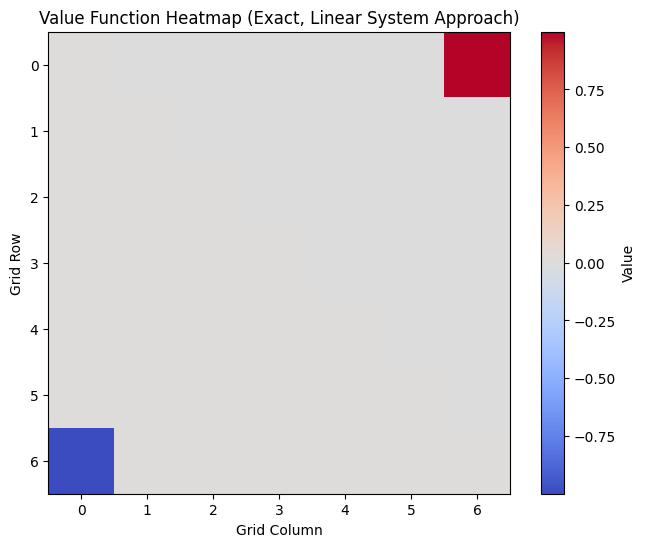

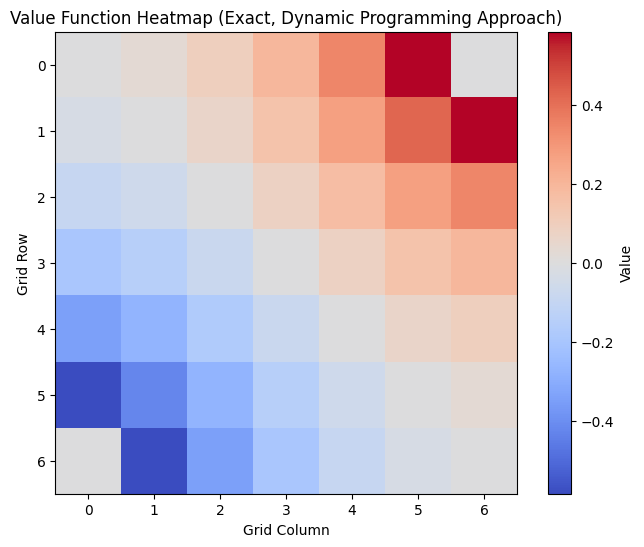

In [1]:
# Cmoparin both the linear and dynamic programming code.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self, size=7):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start_state = (size // 2, size // 2)
        self.terminal_states = {(0, size - 1): 1, (size - 1, 0): -1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row -= 1
        elif action == 1:  # right
            col += 1
        elif action == 2:  # down
            row += 1
        elif action == 3:  # left
            col -= 1

        if (row, col) in self.terminal_states:
            return (row, col), self.terminal_states[(row, col)], True
        elif row < 0 or row >= self.size or col < 0 or col >= self.size:
            return self.state, 0, False
        else:
            self.state = (row, col)
            return self.state, 0, False

def exact_value_function(env, regularization=1e-6):
    size = env.size
    num_states = size * size
    A = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    
    def state_to_index(state):
        return state[0] * size + state[1]
    
    for row in range(size):
        for col in range(size):
            state = (row, col)
            idx = state_to_index(state)
            
            if state in env.terminal_states:
                A[idx, idx] = 1
                b[idx] = env.terminal_states[state]
            else:
                A[idx, idx] = 1
                for action in env.actions:
                    env.state = state  # Reset the state to the current state
                    next_state, reward, _ = env.step(action)
                    next_idx = state_to_index(next_state)
                    A[idx, next_idx] -= 1 / 4
                    b[idx] -= reward / 4
    
    # Adding regularization to avoid singular matrix error
    A += regularization * np.eye(num_states)
    
    # Solve the linear system of equations to get the exact value function
    v = np.linalg.solve(A, b)
    return v.reshape((size, size))

# Dynamic Programming Approach for Exact Value Function
def exact_value_function_dp(env, gamma=0.99, theta=1e-10):
    size = env.size
    value_function = np.zeros((size, size))
    delta = float('inf')

    def is_terminal(state):
        return state in env.terminal_states

    def next_state(state, action):
        env.state = state
        next_state, _, _ = env.step(action)
        return next_state

    def get_reward(state):
        if state in env.terminal_states:
            return env.terminal_states[state]
        return 0

    while delta > theta:
        delta = 0
        new_value_function = np.copy(value_function)
        for i in range(size):
            for j in range(size):
                state = (i, j)
                if is_terminal(state):
                    continue
                v = 0
                for action in env.actions:
                    next_state_ = next_state(state, action)
                    reward = get_reward(next_state_)
                    v += (0.25 * (reward + gamma * value_function[next_state_]))
                new_value_function[state] = v
                delta = max(delta, np.abs(v - value_function[state]))
        value_function = new_value_function

    return value_function

env = GridWorld()

# Computing the exact value function using both methods
value_function_exact = exact_value_function(env)
value_function_dp = exact_value_function_dp(env)

# Convert the value functions to pandas DataFrames
value_function_exact_df = pd.DataFrame(value_function_exact)
value_function_dp_df = pd.DataFrame(value_function_dp)

# Display the value function DataFrames
print("Exact Value Function (Linear System Approach):")
print(value_function_exact_df)
print("\nExact Value Function (Dynamic Programming Approach):")
print(value_function_dp_df)

# Plotting the heatmap of the exact value function (Linear System Approach)
plt.figure(figsize=(8, 6))
plt.imshow(value_function_exact, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Value Function Heatmap (Exact, Linear System Approach)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.show()

# Plotting the heatmap of the exact value function (Dynamic Programming Approach)
plt.figure(figsize=(8, 6))
plt.imshow(value_function_dp, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Value Function Heatmap (Exact, Dynamic Programming Approach)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 7
num_episodes = 10000
alpha = 0.1
gamma = 1.0

# Initialize the grid
grid = np.zeros((grid_size, grid_size))
start_state = (grid_size // 2, grid_size // 2)
terminal_states = {(grid_size - 1, 0): -1, (0, grid_size - 1): 1}

def is_terminal(state):
    return state in terminal_states

def get_reward(state):
    return terminal_states.get(state, 0)

def random_policy(state):
    return np.random.choice(['up', 'down', 'left', 'right'])

def next_state(state, action):
    i, j = state
    if action == 'up':
        return (max(i - 1, 0), j)
    elif action == 'down':
        return (min(i + 1, grid_size - 1), j)
    elif action == 'left':
        return (i, max(j - 1, 0))
    elif action == 'right':
        return (i, min(j + 1, grid_size - 1))
    return state

# Gradient Monte Carlo method
def gradient_monte_carlo():
    value_function = np.zeros((grid_size, grid_size))
    returns = {}

    for _ in range(num_episodes):
        state = start_state
        episode = []
        while not is_terminal(state):
            action = random_policy(state)
            next_state_ = next_state(state, action)
            reward = get_reward(next_state_)
            episode.append((state, reward))
            state = next_state_

        G = 0
        for (state, reward) in reversed(episode):
            G = gamma * G + reward
            if state not in [x[0] for x in episode[:episode.index((state, reward))]]:
                if state not in returns:
                    returns[state] = []
                returns[state].append(G)
                value_function[state] = np.mean(returns[state])

    return value_function

# Semi-Gradient TD(0) method with affine function approximation
def semi_gradient_td():
    value_function = np.zeros((grid_size, grid_size))
    w = np.zeros(grid_size * grid_size)

    def feature_vector(state):
        vec = np.zeros(grid_size * grid_size)
        vec[state[0] * grid_size + state[1]] = 1
        return vec

    for _ in range(num_episodes):
        state = start_state
        while not is_terminal(state):
            action = random_policy(state)
            next_state_ = next_state(state, action)
            reward = get_reward(next_state_)
            state_features = feature_vector(state)
            next_state_features = feature_vector(next_state_)

            delta = reward + gamma * np.dot(w, next_state_features) - np.dot(w, state_features)
            w += alpha * delta * state_features
            state = next_state_

    for i in range(grid_size):
        for j in range(grid_size):
            value_function[i, j] = np.dot(w, feature_vector((i, j)))

    return value_function

# Compute exact value function using Dynamic Programming (for comparison)
def exact_value_function():
    value_function = np.zeros((grid_size, grid_size))
    theta = 1e-10
    delta = float('inf')

    while delta > theta:
        delta = 0
        new_value_function = np.copy(value_function)
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if is_terminal(state):
                    continue
                v = 0
                for action in ['up', 'down', 'left', 'right']:
                    next_state_ = next_state(state, action)
                    reward = get_reward(next_state_)
                    v += (0.25 * (reward + gamma * value_function[next_state_]))
                new_value_function[state] = v
                delta = max(delta, np.abs(v - value_function[state]))
        value_function = new_value_function

    return value_function

# Calculate value functions
mc_value_function = gradient_monte_carlo()
td_value_function = semi_gradient_td()
exact_value_function = exact_value_function()

# Plot the value functions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mc_value_function, cmap='cool')
axes[0].set_title("Monte Carlo Value Function")
axes[1].imshow(td_value_function, cmap='cool')
axes[1].set_title("Semi-Gradient TD(0) Value Function")
axes[2].imshow(exact_value_function, cmap='cool')
axes[2].set_title("Exact Value Function")

plt.show()


Try 3

# Exact Value Function

Exact Value Function (Dynamic Programming Approach):
              0             1         2         3         4             5  \
0  1.749387e-18  3.068081e-02  0.093282  0.192963  0.344374  5.845415e-01   
1 -3.068081e-02  2.602085e-18  0.059972  0.149028  0.269533  4.227669e-01   
2 -9.328206e-02 -5.997172e-02  0.000000  0.079666  0.172853  2.695331e-01   
3 -1.929626e-01 -1.490279e-01 -0.079666  0.000000  0.079666  1.490279e-01   
4 -3.443744e-01 -2.695331e-01 -0.172853 -0.079666  0.000000  5.997172e-02   
5 -5.845415e-01 -4.227669e-01 -0.269533 -0.149028 -0.059972  6.938894e-18   
6  0.000000e+00 -5.845415e-01 -0.344374 -0.192963 -0.093282 -3.068081e-02   

              6  
0  0.000000e+00  
1  5.845415e-01  
2  3.443744e-01  
3  1.929626e-01  
4  9.328206e-02  
5  3.068081e-02  
6  4.336809e-18  


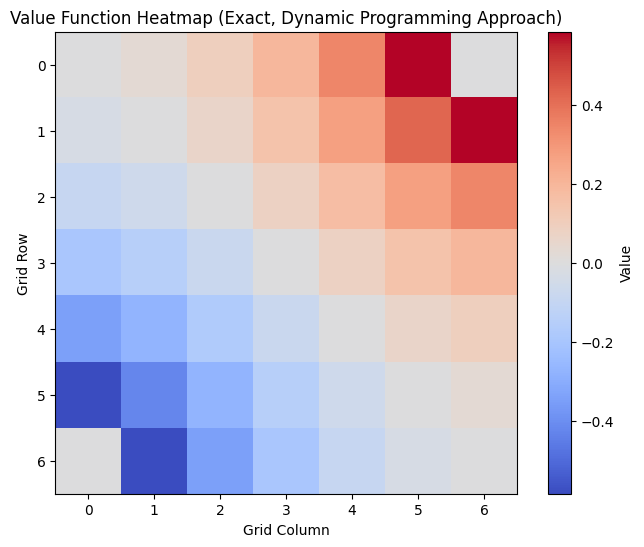

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self, size=7):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start_state = (size // 2, size // 2)
        self.terminal_states = {(0, size - 1): 1, (size - 1, 0): -1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row -= 1
        elif action == 1:  # right
            col += 1
        elif action == 2:  # down
            row += 1
        elif action == 3:  # left
            col -= 1

        if (row, col) in self.terminal_states:
            return (row, col), self.terminal_states[(row, col)], True
        elif row < 0 or row >= self.size or col < 0 or col >= self.size:
            return self.state, 0, False
        else:
            self.state = (row, col)
            return self.state, 0, False

# Dynamic Programming Approach for Exact Value Function
def exact_value_function_dp(env, gamma=0.99, theta=1e-10):
    size = env.size
    value_function = np.zeros((size, size))
    delta = float('inf')

    def is_terminal(state):
        return state in env.terminal_states

    def next_state(state, action):
        env.state = state
        next_state, _, _ = env.step(action)
        return next_state

    def get_reward(state):
        if state in env.terminal_states:
            return env.terminal_states[state]
        return 0

    while delta > theta:
        delta = 0
        new_value_function = np.copy(value_function)
        for i in range(size):
            for j in range(size):
                state = (i, j)
                if is_terminal(state):
                    continue
                v = 0
                for action in env.actions:
                    next_state_ = next_state(state, action)
                    reward = get_reward(next_state_)
                    v += (0.25 * (reward + gamma * value_function[next_state_]))
                new_value_function[state] = v
                delta = max(delta, np.abs(v - value_function[state]))
        value_function = new_value_function

    return value_function

env = GridWorld()

# Computing the exact value function using Dynamic Programming Approach
value_function_dp = exact_value_function_dp(env)

# Convert the value function to pandas DataFrame
value_function_dp_df = pd.DataFrame(value_function_dp)

# Display the value function DataFrame
print("Exact Value Function (Dynamic Programming Approach):")
print(value_function_dp_df)

# Plotting the heatmap of the exact value function (Dynamic Programming Approach)
plt.figure(figsize=(8, 6))
plt.imshow(value_function_dp, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Value Function Heatmap (Exact, Dynamic Programming Approach)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.show()


# Gradient Monte Carlo Question

          0         1         2         3         4         5         6
0  0.206781  0.055889  0.212982  0.144878  0.473190  0.666294  0.000000
1  0.044452  0.118089  0.173069  0.239512  0.359211  0.430618  0.400191
2 -0.030184 -0.001097  0.131223  0.289331  0.220474  0.268174  0.410508
3 -0.347869 -0.194077  0.146803  0.289970  0.316121  0.313997  0.393062
4 -0.422788 -0.279092  0.032782  0.117581  0.058866  0.033489  0.225425
5 -0.665724 -0.455777 -0.143994 -0.013033 -0.011122 -0.011221 -0.050446
6  0.000000 -0.563713 -0.245096 -0.135669  0.117941  0.127066  0.013286


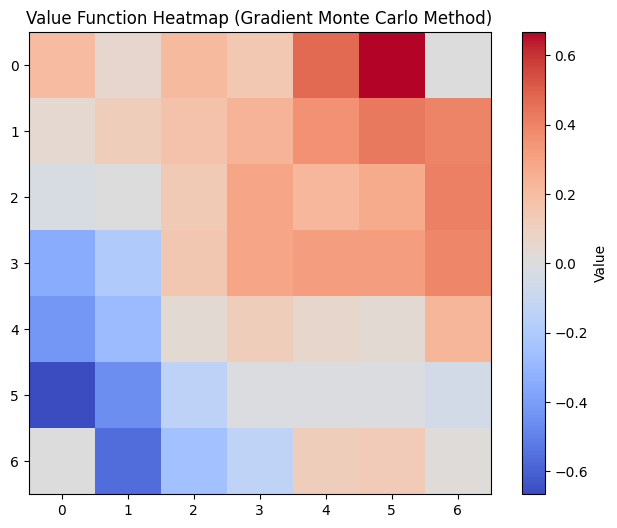

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self, size=7):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start_state = (size // 2, size // 2)
        self.terminal_states = {(0, size - 1): 1, (size - 1, 0): -1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row -= 1
        elif action == 1:  # right
            col += 1
        elif action == 2:  # down
            row += 1
        elif action == 3:  # left
            col -= 1

        if (row, col) in self.terminal_states:
            return (row, col), self.terminal_states[(row, col)], True
        elif row < 0 or row >= self.size or col < 0 or col >= self.size:
            return self.state, 0, False
        else:
            self.state = (row, col)
            return self.state, 0, False

# Gradient Monte Carlo method for estimating the value function
def gradient_monte_carlo(env, num_episodes, alpha=0.01):
    # Initialize weights for the value function approximation
    w = np.zeros(env.size * env.size)
    
    def feature_vector(state):
        vec = np.zeros(env.size * env.size)
        vec[state[0] * env.size + state[1]] = 1
        return vec
    
    def value(state):
        return np.dot(w, feature_vector(state))
    
    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state
            if done:
                break
        
        G = 0
        for state, reward in reversed(episode):
            G = reward + G
            w += alpha * (G - value(state)) * feature_vector(state)
    
    # Reshape the value function weights into a grid
    value_function = np.reshape(w, (env.size, env.size))
    return value_function

env = GridWorld()
num_episodes = 100000
value_function = gradient_monte_carlo(env, num_episodes)

# Convert value function to DataFrame
value_df = pd.DataFrame(value_function)
print(value_df)

# Plotting the heatmap of the value function
plt.figure(figsize=(8, 6))
plt.imshow(value_function, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Value Function Heatmap (Gradient Monte Carlo Method)')
plt.show()



# Semi-gradient TD(0) method with an affine function approximation

          0         1         2         3         4         5         6
0  0.019319  0.058530  0.126487  0.234172  0.404632  0.640463  0.000000
1 -0.014682  0.017168  0.095053  0.186024  0.311554  0.464921  0.592670
2 -0.090252 -0.043025  0.008642  0.100421  0.207670  0.320983  0.367894
3 -0.211278 -0.147712 -0.082251  0.012727  0.105166  0.169792  0.225372
4 -0.368265 -0.284140 -0.191946 -0.081416  0.009086  0.074661  0.122272
5 -0.621301 -0.447600 -0.293203 -0.163077 -0.065275  0.000153  0.045192
6  0.000000 -0.616051 -0.380929 -0.222634 -0.104685 -0.029051  0.011298


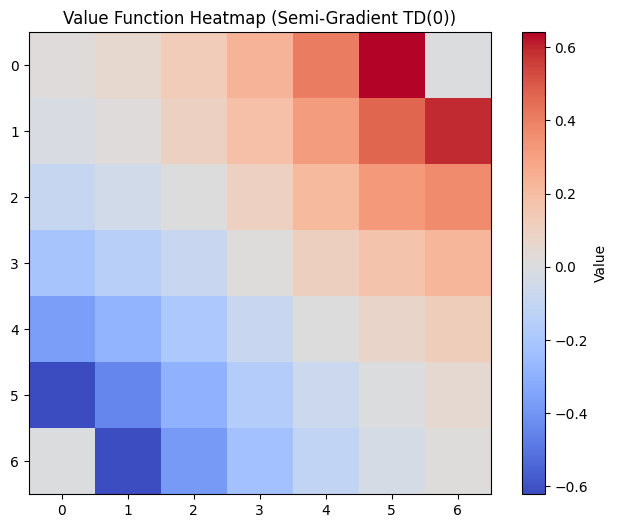

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self, size=7):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start_state = (size // 2, size // 2)
        self.terminal_states = {(0, size - 1): 1, (size - 1, 0): -1}
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row -= 1
        elif action == 1:  # right
            col += 1
        elif action == 2:  # down
            row += 1
        elif action == 3:  # left
            col -= 1

        if (row, col) in self.terminal_states:
            return (row, col), self.terminal_states[(row, col)], True
        elif row < 0 or row >= self.size or col < 0 or col >= self.size:
            return self.state, 0, False
        else:
            self.state = (row, col)
            return self.state, 0, False

# Semi-Gradient TD(0) method with affine function approximation
def semi_gradient_td_0(env, num_episodes, alpha=0.01):
    # Initialize weights for the value function approximation
    w = np.zeros(env.size * env.size)
    
    def feature_vector(state):
        vec = np.zeros(env.size * env.size)
        vec[state[0] * env.size + state[1]] = 1
        return vec
    
    def value(state):
        return np.dot(w, feature_vector(state))
    
    for _ in range(num_episodes):
        state = env.reset()
        
        while True:
            action = np.random.choice(env.actions)
            next_state, reward, done = env.step(action)
            
            td_target = reward + (0 if done else value(next_state))
            td_error = td_target - value(state)
            w += alpha * td_error * feature_vector(state)
            
            state = next_state
            if done:
                break
    
    # Reshape the value function weights into a grid
    value_function = np.reshape(w, (env.size, env.size))
    return value_function

env = GridWorld()
num_episodes = 100000

# Running the semi-gradient TD(0) method
value_function_td = semi_gradient_td_0(env, num_episodes)

# Convert value function to DataFrame
value_df_td = pd.DataFrame(value_function_td)
print(value_df_td)

# Plotting the heatmap of the value function
plt.figure(figsize=(8, 6))
plt.imshow(value_function_td, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Value Function Heatmap (Semi-Gradient TD(0))')
# plt.xlabel('Grid Column')
# plt.ylabel('Grid Row')
plt.show()
